In [1]:
%run ../__init__.ipynb
import tqdm.contrib.concurrent
import statannotations, statannotations.Annotator

In [2]:
df_intact = read_intact_mutations()
dispall(df_intact.head(20))

read_intact_mutations: 78,139 IntAct mutations
read_intact_mutations: 78,119 with defined `Interaction participants`
read_intact_mutations: 70,031 with exactly two participants
read_intact_mutations: 70,031 after parsing participants
read_intact_mutations: 54,369 after filtering participant A for human
read_intact_mutations: 49,495 after filtering participant B for human
read_intact_mutations: 39,919 single-residue substititions
read_intact_mutations: 39,919 effects - neutral: 20042 disrupt/decrease: 16224 no data on effect: 2007 cause/increase: 1646
read_intact_mutations: 32,857 after de-duplication


,variant_id,uniprot_id1,pos,resid,resid_id,uniprot_id2,interaction_id,effect
0,P50402/Y34A,P50402,34,Y,Y34,Q9NYF8,P50402_Q9NYF8,no data on effect
1,P50402/E35A,P50402,35,E,E35,Q9NYF8,P50402_Q9NYF8,no data on effect
2,P50402/K36A,P50402,36,K,K36,Q9NYF8,P50402_Q9NYF8,no data on effect
3,P50402/K37A,P50402,37,K,K37,Q9NYF8,P50402_Q9NYF8,no data on effect
4,Q99558/K429A,Q99558,429,K,K429,O43318-3,O43318-3_Q99558,no data on effect
5,Q99558/K430A,Q99558,430,K,K430,O43318-3,O43318-3_Q99558,no data on effect
6,P49768-2/A430E,P49768-2,430,A,A430,A4FUJ8,A4FUJ8_P49768-2,no data on effect
7,O00187-1/S633A,O00187-1,633,S,S633,P48740-3,O00187-1_P48740-3,no data on effect
8,Q15418/Q724A,Q15418,724,Q,Q724,P28482,P28482_Q15418,no data on effect
9,P83105/S328A,P83105,328,S,S328,Q92743,P83105_Q92743,no data on effect


In [3]:
intact_ = set(df_intact['interaction_id'])
printlen(intact_, 'unique interactions with at least one IntAct mutation')

df_models = suppl_ppi_models(pdockq=.5)

def pdb_trim_(pdb_):
    relpath = os.path.relpath(pdb_, '/cluster/work/beltrao/jjaenes/23.12.06_ppi_reselect/af2-models-split')
    adjpath = os.path.join('/cluster/work/beltrao/jjaenes/23.12.06_ppi_reselect/af2-models-split-trim_bf', relpath)
    return adjpath

df_models['pdb'] = df_models['pdb'].map(lambda fp: os.path.join('/cluster/work/beltrao/jjaenes/23.12.06_ppi_reselect/af2-models-split', fp))
df_models['pdb_trim_bf'] = df_models['pdb'].map(pdb_trim_)
printlen(df_models, 'interactions modelled')

df_models = df_models.query('interaction_id in @intact_').reset_index(drop=True)
printlen(df_models, 'interactions modelled and with an IntAct mutation')

7,816 unique interactions with at least one IntAct mutation
24,074 interactions modelled
817 interactions modelled and with an IntAct mutation


In [4]:
df_models['resid1'], df_models['resid2'] = zip(*tqdm.contrib.concurrent.process_map(get_AFmultimer_resid, df_models.pdb, max_workers=slurm_ntasks()))

  0%|          | 0/817 [00:00<?, ?it/s]

In [5]:
def ifresid_3_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=3, min_pLDDT=0)
def ifresid_5_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=5, min_pLDDT=0)
def ifresid_8_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=8, min_pLDDT=0)
def ifresid_10_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=10, min_pLDDT=0)

def ifresid_3_trim_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=3, min_pLDDT=70)
def ifresid_5_trim_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=5, min_pLDDT=70)
def ifresid_8_trim_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=8, min_pLDDT=70)
def ifresid_10_trim_(pdb_): return get_AFmultimer_ifresid(pdb_, min_distance=10, min_pLDDT=70)

df_models['resid1_3'], df_models['resid2_3'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_3_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_5'], df_models['resid2_5'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_5_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_8'], df_models['resid2_8'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_8_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_10'], df_models['resid2_10'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_10_, df_models.pdb, max_workers=slurm_ntasks()))

df_models['resid1_3_trim'], df_models['resid2_3_trim'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_3_trim_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_5_trim'], df_models['resid2_5_trim'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_5_trim_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_8_trim'], df_models['resid2_8_trim'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_8_trim_, df_models.pdb, max_workers=slurm_ntasks()))
df_models['resid1_10_trim'], df_models['resid2_10_trim'] = zip(*tqdm.contrib.concurrent.process_map(ifresid_10_trim_, df_models.pdb, max_workers=slurm_ntasks()))

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

  0%|          | 0/817 [00:00<?, ?it/s]

In [6]:
def resid_check(r):
    #if r.interaction_id.startswith(r.uniprot_id1):
    if r.uniprot_id1_intact == r.uniprot_id1_models:
        return r.resid_id in set(r.resid1)
    #elif r.interaction_id.startswith(r.uniprot_id2):
    elif r.uniprot_id1_intact == r.uniprot_id2_models:
        return r.resid_id in set(r.resid2)
    assert False

df_effect = df_intact.merge(df_models, on='interaction_id', suffixes=('_intact', '_models'))
printlen(df_effect, 'Intact mutations with modelled interaction')
df_effect['resid_check'] = df_effect.apply(resid_check, axis=1)
df_effect = df_effect.query('resid_check == True')
printlen(df_effect, 'Intact mutations with matching residues')

9,854 Intact mutations with modelled interaction
8,430 Intact mutations with matching residues


In [7]:
df_effect['isin_resid3'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_3) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_3), axis=1)
df_effect['isin_resid5'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_5) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_5), axis=1)
df_effect['isin_resid8'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_8) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_8), axis=1)
df_effect['isin_resid10'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_10) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_10), axis=1)

df_effect['isin_resid10'] = df_effect['isin_resid10'] & ~df_effect['isin_resid8']
df_effect['isin_resid8'] = df_effect['isin_resid8'] & ~df_effect['isin_resid5']
df_effect['isin_resid5'] = df_effect['isin_resid5'] & ~df_effect['isin_resid3']
df_effect['isin_resid3'] = df_effect['isin_resid3'] #& ~df_effect['isin_resid2']

df_effect['isin_resid3_trim'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_3_trim) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_3_trim), axis=1)
df_effect['isin_resid5_trim'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_5_trim) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_5_trim), axis=1)
df_effect['isin_resid8_trim'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_8_trim) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_8_trim), axis=1)
df_effect['isin_resid10_trim'] = df_effect.apply(lambda r: r.resid_id in set(r.resid1_10_trim) if r.uniprot_id1_intact == r.uniprot_id1_models else r.resid_id in set(r.resid2_10_trim), axis=1)

df_effect['isin_resid10_trim'] = df_effect['isin_resid10_trim'] & ~df_effect['isin_resid8_trim']
df_effect['isin_resid8_trim'] = df_effect['isin_resid8_trim'] & ~df_effect['isin_resid5_trim']
df_effect['isin_resid5_trim'] = df_effect['isin_resid5_trim'] & ~df_effect['isin_resid3_trim']
df_effect['isin_resid3_trim'] = df_effect['isin_resid3_trim'] #& ~df_effect['isin_resid2_trim']

In [8]:
def fisher_exact_(ifresid_col_, subset_col_):
    counts_ = pd.crosstab(df_effect[ifresid_col_], df_effect[subset_col_])[['neutral', 'disrupt/decrease']]
    #counts_ = pd.crosstab(df_effect[ifresid_col_], df_effect[subset_col_])[['neutral', 'cause/increase']]
    print(counts_)
    statistic, pvalue = sp.stats.fisher_exact(counts_.values)
    return [statistic, pvalue, pvalue_label(pvalue)]

data_ = pd.DataFrame.from_records([
    #['<2Å', 'All'] + fisher_exact_('isin_resid2', 'effect'),
    ['<3Å', 'All'] + fisher_exact_('isin_resid3', 'effect'),
    ['3-5Å', 'All'] + fisher_exact_('isin_resid5', 'effect'),
    ['5-8Å', 'All'] + fisher_exact_('isin_resid8', 'effect'),
    ['8-10Å',  'All'] + fisher_exact_('isin_resid10', 'effect'),
    #['<2Å', 'pLDDT>70'] + fisher_exact_('isin_resid2_trim', 'effect'),
    ['<3Å', 'pLDDT>70'] + fisher_exact_('isin_resid3_trim', 'effect'),
    ['3-5Å', 'pLDDT>70'] + fisher_exact_('isin_resid5_trim', 'effect'),
    ['5-8Å', 'pLDDT>70'] + fisher_exact_('isin_resid8_trim', 'effect'),
    ['8-10Å', 'pLDDT>70'] + fisher_exact_('isin_resid10_trim', 'effect'),
], columns=['cutoff', 'Residue filter', 'odds_ratio', 'pvalue', 'pvalue_label'])
data_

effect       neutral  disrupt/decrease
isin_resid3                           
False           6456              1404
True             232               182
effect       neutral  disrupt/decrease
isin_resid5                           
False           5975              1195
True             713               391
effect       neutral  disrupt/decrease
isin_resid8                           
False           5819              1339
True             869               247
effect        neutral  disrupt/decrease
isin_resid10                           
False            6271              1479
True              417               107
effect            neutral  disrupt/decrease
isin_resid3_trim                           
False                6510              1428
True                  178               158
effect            neutral  disrupt/decrease
isin_resid5_trim                           
False                6066              1212
True                  622               374
effect            ne

,cutoff,Residue filter,odds_ratio,pvalue,pvalue_label
0,<3Å,All,3.607280,1.625024e-32,p≤0.0001
1,3-5Å,All,2.741935,3.055187e-43,p≤0.0001
2,5-8Å,All,1.235222,7.843404e-03,p≤0.01
3,8-10Å,All,1.087969,4.560736e-01,p=0.46
4,<3Å,pLDDT>70,4.046596,1.971021e-32,p≤0.0001
5,3-5Å,pLDDT>70,3.009408,3.779468e-48,p≤0.0001
6,5-8Å,pLDDT>70,1.213129,2.340201e-02,p≤0.05
7,8-10Å,pLDDT>70,1.171425,1.833016e-01,p=0.18


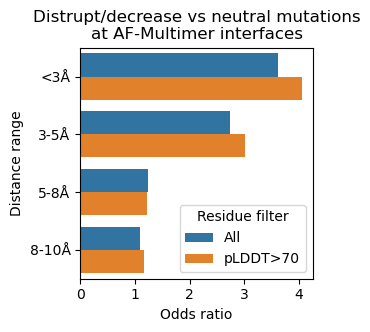

In [9]:
#plt.figure(figsize=(3, 3))
#plt.title('IntAct mutations with experimental evidence')
#sns.barplot(data_, x='odds_ratio', orient='h'_
#args_ = {
#    'data': data_.query('subset != "no data on effect"').copy(),
#    'orient': 'h',
#    'y': 'subset',
#    'x': 'size',
#    'hue': 'interface_label',
#    'order': ['neutral', 'disrupt/decrease', 'cause/increase']#, 'no data on effect',],
#}

#pairs_ = [
#    (('neutral', False), ('disrupt/decrease', True)),
#    (('neutral', False), ('cause/increase', True)),
#]

#def counts_(subset_):
#    return data_.query('subset == @subset_').sort_values('interface_label', ascending=False)['size'].values#

#stats_ = [
#    sp.stats.fisher_exact([counts_('disrupt/decrease'), counts_('neutral')]).pvalue,
#    sp.stats.fisher_exact([counts_('cause/increase'), counts_('neutral')]).pvalue,
#]
#print(stats_)

plt.figure(figsize=(3, 3))
plt.title('Distrupt/decrease vs neutral mutations\nat AF-Multimer interfaces')
sns.barplot(data=data_, y='cutoff', x='odds_ratio', hue='Residue filter')
#annotator = statannotations.Annotator.Annotator(plt.gca(), pairs_, **args_)
#annotator.configure()
#annotator.set_custom_annotations([* map(pvalue_label, stats_) ])
#annotator.annotate()
plt.gca().set_xlabel('Odds ratio')
plt.gca().set_ylabel('Distance range')
#plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
#plt.gca().legend(loc='lower right', title='Filtering')
plt.savefig('enrichments_IntAct_.svg', bbox_inches='tight', transparent=True)